In [98]:
from No_sync.Frost_api import client_id, client_secret
import requests
import pandas as pd
from datetime import datetime, timedelta

<h2>API Call</h2>

In [99]:
# SN65320, SN65310, SN65370 
# Closest station gave error, so I used the second closest station
# air_temperature, precipitation_amount, wind_speed, relative_humidity, 

In [100]:
# Define the endpoint and parameters
endpoint = 'https://frost.met.no/observations/v0.jsonld'

# Calculate the date range for the last year
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

# Format the date range as a string
date_range = start_date.strftime('%Y-%m-%d') + '/' + end_date.strftime('%Y-%m-%d')

parameters = {
    'sources': 'SN65370, SN65310',
    'elements': 'mean(air_temperature P1D),sum(precipitation_amount P1D),mean(wind_speed P1D),mean(relative_humidity P1D)',
    'referencetime': date_range,
}

# Issue an HTTP GET request
r = requests.get(endpoint, params=parameters, auth=(client_id, ''))

# Extract JSON data
json = r.json()


In [101]:
# Check if the request worked, print out any errors
if r.status_code == 200:
    data = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

Data retrieved from frost.met.no!


<h2>From JSON to pandas dataframe</h2>

In [102]:
# make a dataframe
df_total = pd.DataFrame()
for i in range(len(data)):
    row = pd.DataFrame(data[i]['observations'])
    row['referenceTime'] = data[i]['referenceTime']
    row['sourceId'] = data[i]['sourceId']

    df_total = pd.concat([row, df_total])

In [103]:
# These additional columns will be kept
columns = ['sourceId','referenceTime','elementId','value','unit','timeOffset']
df = df_total[columns].copy()
# Convert the time value to something Python understands
df['referenceTime'] = pd.to_datetime(df['referenceTime'])

In [104]:
df

,sourceId,referenceTime,elementId,value,unit,timeOffset
0,SN65370:0,2023-10-12 00:00:00+00:00,sum(precipitation_amount P1D),16.6,mm,PT6H
0,SN65370:0,2023-10-11 00:00:00+00:00,sum(precipitation_amount P1D),16.5,mm,PT6H
0,SN65370:0,2023-10-10 00:00:00+00:00,sum(precipitation_amount P1D),4.7,mm,PT6H
0,SN65370:0,2023-10-09 00:00:00+00:00,sum(precipitation_amount P1D),6.8,mm,PT6H
0,SN65370:0,2023-10-08 00:00:00+00:00,sum(precipitation_amount P1D),23.7,mm,PT6H
...,...,...,...,...,...,...
3,SN65310:0,2022-10-14 00:00:00+00:00,mean(relative_humidity P1D),80.0,percent,PT0H
0,SN65310:0,2022-10-13 00:00:00+00:00,mean(air_temperature P1D),9.3,degC,PT0H
1,SN65310:0,2022-10-13 00:00:00+00:00,mean(air_temperature P1D),10.1,degC,PT6H
2,SN65310:0,2022-10-13 00:00:00+00:00,mean(wind_speed P1D),6.2,m/s,PT0H


In [ ]:
#get unique values in elementId
df['elementId'].unique()

In [ ]:
# make df to csv
df.to_csv('Data/weather.csv', index=False)

<h2>Plots for fun</h2>

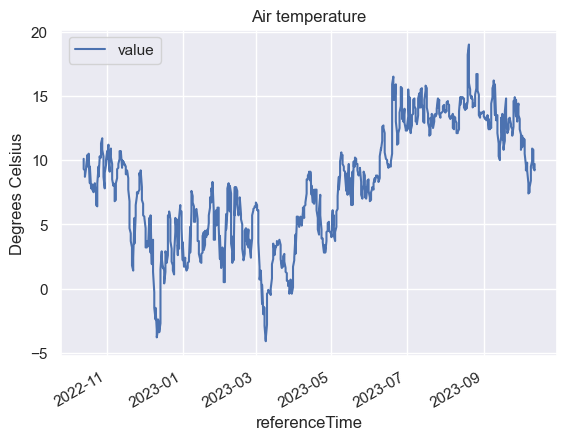

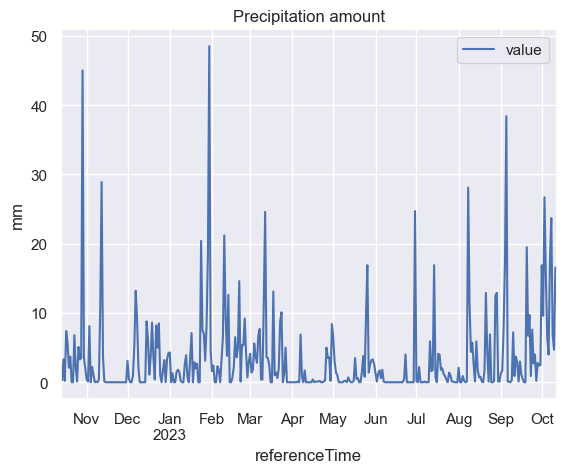

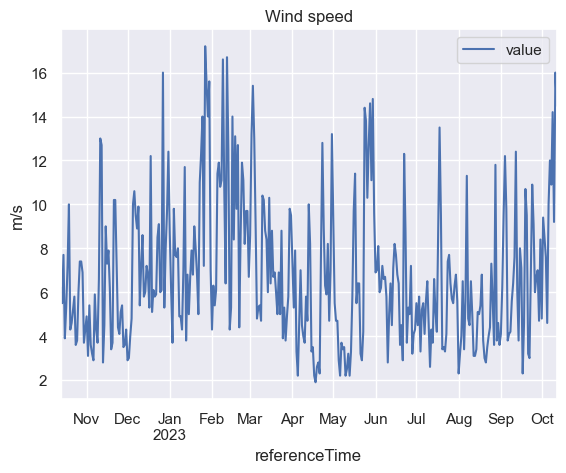

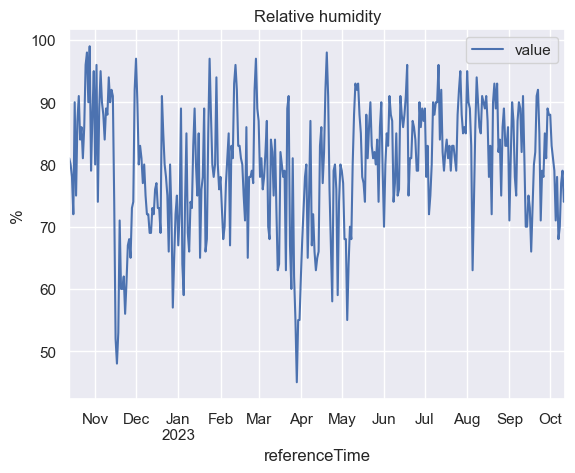

In [108]:
# plot values for each element based on time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# plot air_temperature
df_air_temperature = df[df['elementId'] == 'mean(air_temperature P1D)']
df_air_temperature = df_air_temperature[['referenceTime','value']]
df_air_temperature = df_air_temperature.set_index('referenceTime')
df_air_temperature.plot()
plt.title('Air temperature')
plt.ylabel('Degrees Celsius')
plt.show()

# plot precipitation_amount
df_precipitation_amount = df[df['elementId'] == 'sum(precipitation_amount P1D)']
df_precipitation_amount = df_precipitation_amount[['referenceTime','value']]
df_precipitation_amount = df_precipitation_amount.set_index('referenceTime')
df_precipitation_amount.plot()
plt.title('Precipitation amount')
plt.ylabel('mm')
plt.show()

# plot wind_speed
df_wind_speed = df[df['elementId'] == 'mean(wind_speed P1D)']
df_wind_speed = df_wind_speed[['referenceTime','value']]
df_wind_speed = df_wind_speed.set_index('referenceTime')
df_wind_speed.plot()
plt.title('Wind speed')
plt.ylabel('m/s')
plt.show()

# plot relative_humidity
df_relative_humidity = df[df['elementId'] == 'mean(relative_humidity P1D)']
df_relative_humidity = df_relative_humidity[['referenceTime','value']]
df_relative_humidity = df_relative_humidity.set_index('referenceTime')
df_relative_humidity.plot()
plt.title('Relative humidity')
plt.ylabel('%')
plt.show()


In [92]:
# Convert all column names to lower case
df.columns = df.columns.str.lower()

<h2>Connecting to Cassandra Cluster</h2>

In [77]:
# Connecting to Cassandra
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

In [78]:
# Creating a keyspace
session.execute("CREATE KEYSPACE IF NOT EXISTS fish_keyspace WITH REPLICATION = { 'class' : 'SimpleStrategy', 'replication_factor' : 1 };")

In [79]:
# set keyspace
session.set_keyspace('fish_keyspace')

In [80]:
# Drop the table if it already exists
session.execute("DROP TABLE IF EXISTS fish_keyspace.weather_table;") 

# Create a new table with primary keys
session.execute("""
   CREATE TABLE IF NOT EXISTS weather_table (
    sourceid TEXT,
    elementid TEXT,
    value DOUBLE,
    unit TEXT,
    timeoffset TEXT,
    referencetime DATE,
    PRIMARY KEY (elementid, timeoffset, referencetime)
);
""")


<h2>From Pandas dataframe to Spark dataframe</h2>

In [81]:
import os
os.environ["JAVA_HOME"] = "C:\Program Files\Java\jdk-20"
# If you are using environments in Python, you can set the environment variables like this:
os.environ["PYSPARK_PYTHON"] = "python" # or similar to "/Users/kristian/miniforge3/envs/tf_M1/bin/python"
#os.environ["PYSPARK_DRIVER_PYTHON"] = "python" # or similar to "/Users/kristian/miniforge3/envs/tf_M1/bin/python"
# Set the Hadoop version to the one you are using, e.g., none:
#os.environ["PYSPARK_HADOOP_VERSION"] = "without"

In [82]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()
# Some warnings are to be expected.

In [94]:
# Read the data from the csv files
weather_data = spark.read.csv('Data/weather.csv', header=True, inferSchema=True)

In [95]:
# Write the data to Cassandra
keyspace = "fish_keyspace"
table = "weather_table"

weather_data.write \
    .format("org.apache.spark.sql.cassandra") \
    .option("table", table) \
    .option("keyspace", keyspace) \
    .mode("append").save()

In [96]:
# Read from Cassandra - fish_table_year
df_weather = spark.read.format("org.apache.spark.sql.cassandra").options(table="weather_table", keyspace="fish_keyspace").load()
df_weather.show()

+--------------------+----------+-------------+---------+----+-----+
|           elementid|timeoffset|referencetime| sourceid|unit|value|
+--------------------+----------+-------------+---------+----+-----+
|mean(wind_speed P1D)|      PT0H|   2022-10-13|SN65310:0| m/s|  6.2|
|mean(wind_speed P1D)|      PT0H|   2022-10-14|SN65310:0| m/s|  5.5|
|mean(wind_speed P1D)|      PT0H|   2022-10-15|SN65310:0| m/s|  7.7|
|mean(wind_speed P1D)|      PT0H|   2022-10-16|SN65310:0| m/s|  3.9|
|mean(wind_speed P1D)|      PT0H|   2022-10-17|SN65310:0| m/s|  5.3|
|mean(wind_speed P1D)|      PT0H|   2022-10-18|SN65310:0| m/s|  7.2|
|mean(wind_speed P1D)|      PT0H|   2022-10-19|SN65310:0| m/s| 10.0|
|mean(wind_speed P1D)|      PT0H|   2022-10-20|SN65310:0| m/s|  4.3|
|mean(wind_speed P1D)|      PT0H|   2022-10-21|SN65310:0| m/s|  4.6|
|mean(wind_speed P1D)|      PT0H|   2022-10-22|SN65310:0| m/s|  5.2|
|mean(wind_speed P1D)|      PT0H|   2022-10-23|SN65310:0| m/s|  5.8|
|mean(wind_speed P1D)|      PT0H| 